In [1]:
from jax import random, jit, vmap
import os
path = os.getcwd()
print("Old path:", path)
path = (path.split('/'))
path = path[:path.index("ABC-SBI")+1]
path = '/'.join(path)
print("New path:", path)
os.chdir(path)
from functions.simulation import get_dataset, get_epsilon_star, get_newdataset
from functions.training import train_loop
from functions.SBC import SBC_epsilon, plot_SBC, find_grid_explorative, post_pdf_z
import jax.numpy as jnp
import time
import pickle 
import lzma
from jax.scipy.stats import norm, gaussian_kde
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
@jit
def prior_simulator(key):
    return random.normal(key, (1,))*SIGMA0 + MU0

@jit
def data_simulator(key, theta):
    return (random.normal(key, (N_DATA,))*SIGMA + theta).astype(float)

@jit
def discrepancy(y, y_true):
    return (jnp.mean(y) - jnp.mean(y_true))**2

def true_post(z):
    mu_post = (MU0*SIGMA**2 + SIGMA0**2 * np.sum(z))/(SIGMA0**2*len(z) + SIGMA**2)
    sigma2_post = 1/(1/SIGMA0**2 + len(z)/SIGMA**2)
    return stats.norm(loc = mu_post, scale = np.sqrt(sigma2_post))


Old path: /Users/antoineluciano/Documents/Recherche/ABC-SBI/examples/Gauss-Gauss
New path: /Users/antoineluciano/Documents/Recherche/ABC-SBI




--------------------
SIGMA0 = 2.0, TRUE_MU = 0.2, ACCEPT_RATE = 1.0
--------------------


Selection of epsilon star...
Distances: min =  4.6307256e-09 max =  59.224213 mean =  4.238362 std =  5.8794403
Time to select epsilon star: 1.33s

Simulations of the testing dataset...
Time to simulate the testing dataset: 1.63s

Simulations of the training dataset...
Time to simulate the training dataset: 1.81s

Training the neural network...
Initial accuracy: 49.98%, Initial test accuracy: 49.86%
Training for 1 epochs...
Epoch 1/1, mean train accuracy: 92.06%, mean test accuracy: 94.52%, lr scale: 1.0 in 20.18 sec
Time to train the neural network: 41.72s

Simulation Based Calibration...


  0%|          | 0/64 [00:00<?, ?it/s]

Time to perform SBC: 12.89s

Data saved in  /Users/antoineluciano/Documents/Recherche/ABC-SBI/examples/Gauss-Gauss/results/sigma0_2.0/mu_0.2/pickles/GaussGauss_sigma_1.0_sigma0_2.0_mu_0.2_acc_1.0_eps_inf.xy


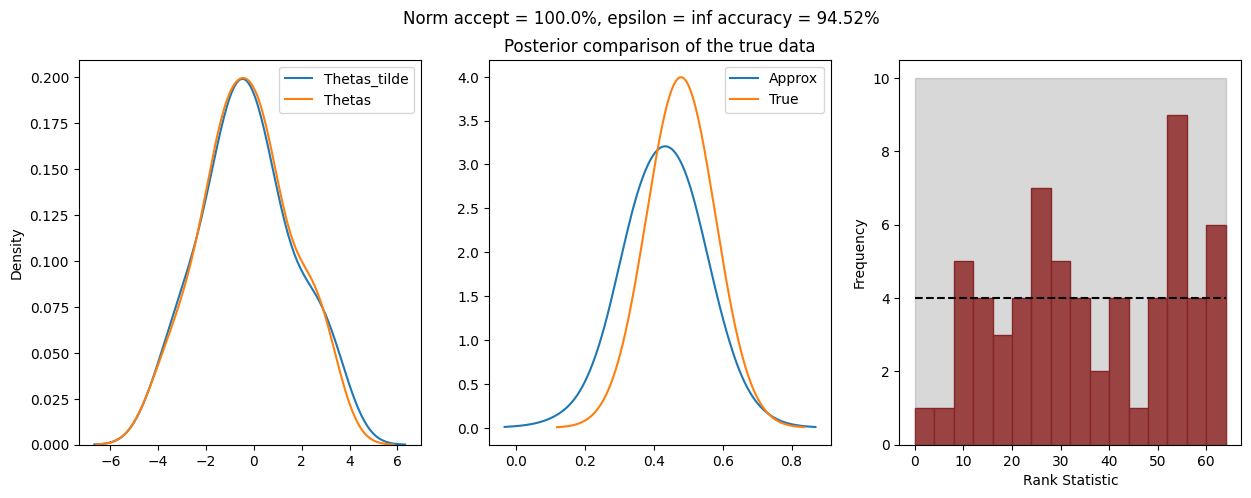



--------------------
ITERATION (ACC = 1.0) DONE IN 61.256455183029175 SECONDS!
--------------------




--------------------
SIGMA0 = 2.0, TRUE_MU = 0.2, ACCEPT_RATE = 0.999
--------------------


Selection of epsilon star...
Distances: min =  1.0899591e-06 max =  72.90308 mean =  4.3240705 std =  6.172764
epsilon:  29.085819244384766 acceptance rate:  0.99899995
Time to select epsilon star: 1.31s

Simulations of the testing dataset...
Time to simulate the testing dataset: 1.00s

Simulations of the training dataset...
Time to simulate the training dataset: 3.12s

Training the neural network...
Initial accuracy: 49.56%, Initial test accuracy: 49.40%
Training for 1 epochs...


KeyboardInterrupt: 

In [ ]:
key = random.PRNGKey(0)
 
MU0 = 0.
SIGMA = 1.
MODEL_ARGS = [SIGMA]
N_DATA = 100
N_POINTS_TRAIN = 1000000
N_POINTS_TEST = 100000
N_POINTS_EPS = 10000
sim_args = None


N_EPOCHS = 1
LEARNING_RATE = 0.001
PATIENCE = 7
COOLDOWN = 0
FACTOR = .5
RTOL = 1e-4  
ACCUMULATION_SIZE = 200
LEARNING_RATE_MIN = 1e-6

BATCH_SIZE = 256
NUM_BATCH = 1024
NUM_CLASSES = 2
HIDDEN_SIZE = 256
NUM_LAYERS = 7
WDECAY = .001
N_GRID_FINAL = 10000
N_GRID_EXPLO = 1000
L = 63
B = 16
N_SBC = (L+1)*1

PATH_RESULTS = os.getcwd() + "/examples/Gauss-Gauss/results/"
if not os.path.exists(PATH_RESULTS):
    os.makedirs(PATH_RESULTS)
    


SIGMAS0 = [2*SIGMA, 5*SIGMA, 10*SIGMA, 20*SIGMA]
ACCEPT_RATES = [1., .999, .99, .975, .95, .925, .9, .85, .8, .75]


for SIGMA0 in SIGMAS0:
    PATH_SIGMA0 = PATH_RESULTS+ "sigma0_{}/".format(SIGMA0)
    if not os.path.exists(PATH_SIGMA0):
        os.makedirs(PATH_SIGMA0)
        
    TRUE_MUS = [.1*SIGMA0, .5*SIGMA0, SIGMA0, 1.5*SIGMA0]
    PRIOR_ARGS = [MU0, SIGMA0]
    PRIOR_LOGPDF = lambda x: norm.logpdf(x, loc = MU0, scale = SIGMA0)
    MINN, MAXX = norm.ppf(1e-5, loc = MU0, scale = SIGMA0), norm.ppf(1-1e-5, loc = MU0, scale = SIGMA0)
    
    for TRUE_MU in TRUE_MUS:
        PATH_TRUE_MU = PATH_SIGMA0 + "mu_{}/".format(TRUE_MU)
        if not os.path.exists(PATH_TRUE_MU):
            os.makedirs(PATH_TRUE_MU)
        EPSILON_STAR = jnp.inf
        key, subkey = random.split(key)
        TRUE_DATA = data_simulator(subkey, TRUE_MU)
        for ACCEPT_RATE in ACCEPT_RATES:
            print("\n\n--------------------")
            print("SIGMA0 = {}, TRUE_MU = {}, ACCEPT_RATE = {}".format(SIGMA0, TRUE_MU, ACCEPT_RATE))
            print("--------------------\n\n")
                    
            
            time_eps = time.time()
            print("Selection of epsilon star...")
            EPSILON_STAR, key = get_epsilon_star(key, ACCEPT_RATE, N_POINTS_EPS, prior_simulator, data_simulator, discrepancy, TRUE_DATA, quantile_rate = .99, epsilon = EPSILON_STAR)
            print('Time to select epsilon star: {:.2f}s\n'.format(time.time()-time_eps))

            print("Simulations of the testing dataset...")
            time_sim = time.time()
            X_test, y_test, key = get_newdataset(key, N_POINTS_TEST, prior_simulator, data_simulator, discrepancy, EPSILON_STAR, TRUE_DATA)
            print('Time to simulate the testing dataset: {:.2f}s\n'.format(time.time()-time_sim))

            print("Simulations of the training dataset...")
            time_sim = time.time()
            X_train, y_train, key = get_newdataset(key, N_POINTS_TRAIN, prior_simulator, data_simulator, discrepancy, EPSILON_STAR, TRUE_DATA)
            print('Time to simulate the training dataset: {:.2f}s\n'.format(time.time()-time_sim))


            print("Training the neural network...")
            time_nn = time.time()
            params, train_accuracy, train_losses, test_accuracy, test_losses, key = train_loop(key, N_EPOCHS, NUM_LAYERS, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE, NUM_BATCH, LEARNING_RATE, WDECAY, PATIENCE, COOLDOWN, FACTOR, RTOL, ACCUMULATION_SIZE, LEARNING_RATE_MIN, prior_simulator, data_simulator, discrepancy, true_data = TRUE_DATA, X_train = X_train, y_train = y_train, X_test = X_test, y_test =  y_test, N_POINTS_TRAIN = N_POINTS_TRAIN, N_POINTS_TEST = N_POINTS_TEST, epsilon = EPSILON_STAR, verbose = True)
            print('Time to train the neural network: {:.2f}s\n'.format(time.time()-time_nn))


            print("Simulation Based Calibration...")
            time_sbc = time.time()

            ranks, thetas_tilde, thetas, key = SBC_epsilon(key = key, N_SBC = N_SBC, L = L, params = params, epsilon = EPSILON_STAR, true_data = TRUE_DATA, prior_simulator = prior_simulator, prior_logpdf = PRIOR_LOGPDF, data_simulator = data_simulator, discrepancy = discrepancy, n_grid_explo = N_GRID_EXPLO, n_grid_final = N_GRID_FINAL, minn = MINN, maxx = MAXX)

            print('Time to perform SBC: {:.2f}s\n'.format(time.time()-time_sbc))


            pickle_dico = {"ACCEPT_RATE":ACCEPT_RATE, "ranks": ranks, "thetas_tilde": thetas_tilde, "thetas": thetas, "epsilon":EPSILON_STAR, "KEY":key, "N_SBC":N_SBC, "L":L, "N_GRID_EXPLO": N_GRID_EXPLO, 'N_GRID_FINAL': N_GRID_FINAL,"TRUE_DATA": TRUE_DATA, "TRUE_THETA": TRUE_MU, "params": params, "train_accuracy":train_accuracy, "test_accuracy":test_accuracy, "MODEL_ARGS":MODEL_ARGS, "PRIOR_ARGS":PRIOR_ARGS, "N_POINTS_TRAIN":N_POINTS_TRAIN, "N_POINTS_TEST":N_POINTS_TEST, "N_DATA":N_DATA, "N_EPOCHS":N_EPOCHS, "LEARNING_RATE":LEARNING_RATE, "PATIENCE":PATIENCE, "COOLDOWN":COOLDOWN, "FACTOR":FACTOR, "RTOL":RTOL, "ACCUMULATION_SIZE":ACCUMULATION_SIZE, "LEARNING_RATE_MIN":LEARNING_RATE_MIN, "BATCH_SIZE":BATCH_SIZE, "NUM_BATCH":NUM_BATCH, "NUM_CLASSES":NUM_CLASSES, "HIDDEN_SIZE":HIDDEN_SIZE, "NUM_LAYERS":NUM_LAYERS, "WDECAY":WDECAY}


            NAME = "GaussGauss_sigma_{}_sigma0_{}_mu_{}_acc_{:.3}_eps_{:.5}".format(SIGMA, SIGMA0, TRUE_MU, ACCEPT_RATE, EPSILON_STAR)
            NAMEFIG = PATH_TRUE_MU+'figures/'+NAME+".png"
            NAMEFILE = PATH_TRUE_MU+'pickles/'+NAME+".xy"
            
            if not os.path.exists(PATH_TRUE_MU+'figures/'):
                os.makedirs(PATH_TRUE_MU+'figures/')
            if not os.path.exists(PATH_TRUE_MU+'pickles/'):
                os.makedirs(PATH_TRUE_MU+'pickles/')
                
            
            with lzma.open(NAMEFILE, "wb") as f:
                pickle.dump(pickle_dico, f)
            print("Data saved in ", NAMEFILE)

            title = "Normal w/ known std\nsigma = {}, sigma0 = {} mu = {}\nalpha = {:.2%}, eps = {:.3} accuracy = {:.2%}".format(SIGMA, SIGMA0, TRUE_MU, ACCEPT_RATE, EPSILON_STAR, test_accuracy[-1])
    
            
            f, ax = plt.subplots(1,3, figsize = (15,5))
            sns.kdeplot(thetas_tilde, label = "Thetas_tilde", ax = ax[0])
            sns.kdeplot(thetas[:,0], label = "Thetas", ax = ax[0])

            ax[0].legend()
            f.suptitle(f'GaussGauss with sigma = {SIGMA} sigma0 = {SIGMA0} mu = {TRUE_MU} alpha = {ACCEPT_RATE:.1%}, epsilon = {EPSILON_STAR:.3} accuracy = {test_accuracy[-1]:.2%}')

            grid_approx, pdf_approx = find_grid_explorative(lambda x: post_pdf_z(params, x, TRUE_DATA, PRIOR_LOGPDF), N_GRID_EXPLO, N_GRID_FINAL, MINN, MAXX)
            grid_true, pdf_true = find_grid_explorative(lambda x: true_post(TRUE_DATA).pdf(x), N_GRID_EXPLO, N_GRID_FINAL, MINN, MAXX)
            
            Z_approx = np.trapz(pdf_approx, grid_approx)
            ax[1].plot(grid_approx, pdf_approx/Z_approx, label = "Approx")
            ax[1].plot(grid_true, pdf_true, label = "True")
            ax[1].legend()
            ax[1].set_title("Posterior comparison of the true data")
            plot_SBC(ranks, L, B, ax = ax[2])
            ax[2].set_title("SBC with Rank Statistics")
            f.savefig(NAMEFIG)
            plt.close(f)
            
            
            
            
            
            print("\n\n--------------------")
            print("ITERATION (ACC = {}) DONE IN {} SECONDS!".format(ACCEPT_RATE, time.time()-time_eps))
            print("--------------------\n\n")

In [ ]:
import os
import lzma
import pickle

# Directory containing the pickle files
directory = PATH_RESULTS+"/pickle"

# List to store the data from each pickle file
data_list = []

# Iterate over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".xy"):
        filepath = os.path.join(directory, filename)
        with lzma.open(filepath, "rb") as f:
            data = pickle.load(f)
            data_list.append(data)

# Print the number of files read
print(f"Number of files read: {len(data_list)}")
key = data_list[0]["KEY"]
L = 15
N_SBC = (L+1)*100
for data in data_list: 
    data["ranks"], data["thetas_tilde"], data["thetas"], key = SBC_epsilon(key = key, N_SBC = N_SBC, L = L, params = data["params"], epsilon = data["epsilon"], true_data = data["TRUE_DATA"], prior_simulator = prior_simulator, prior_logpdf = PRIOR_LOGPDF, data_simulator = data_simulator, discrepancy = discrepancy, n_grid_explo = data["N_GRID_EXPLO"], n_grid_final = data["N_GRID_FINAL"], minn = MINN, maxx = MAXX)
    

Number of files read: 10


  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

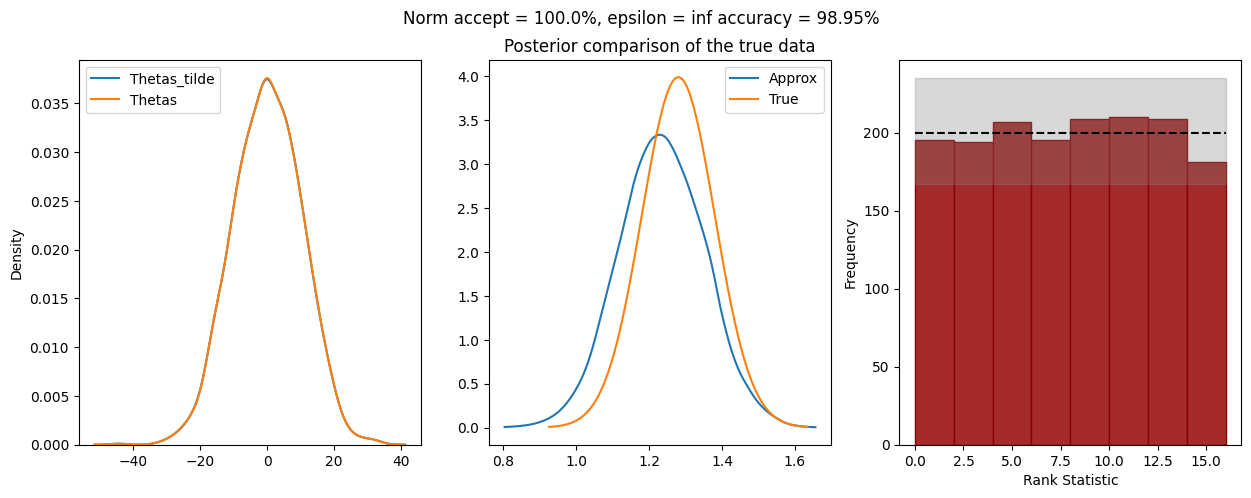

/Users/antoineluciano/Documents/Recherche/ABC-SBI/examples/Gauss-Gauss/results/figures/GaussGauss_sigma_1.0_sigma0_10.0_mu_1.0_acc_1.0_eps_inf


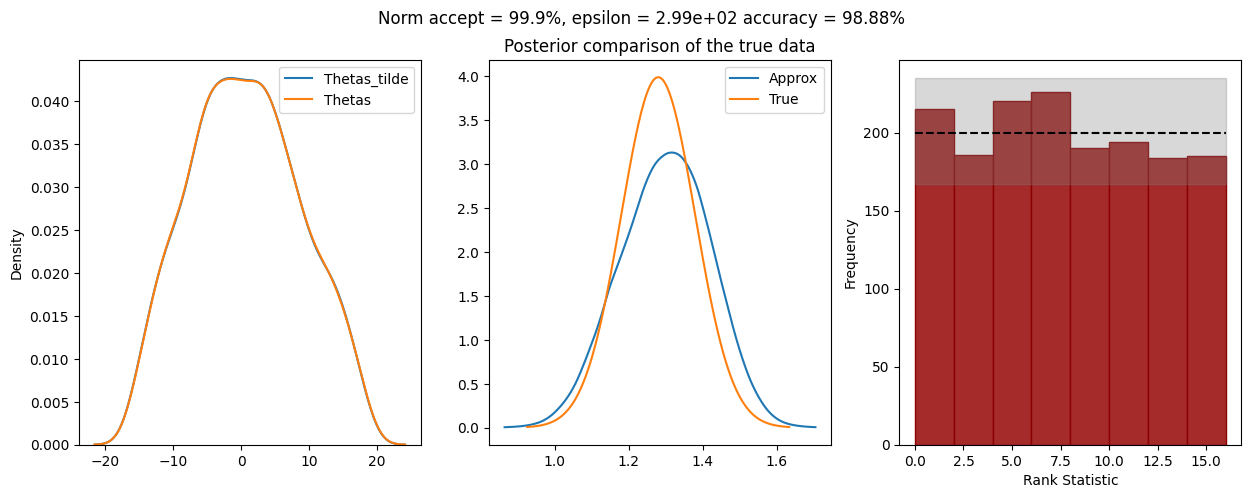

/Users/antoineluciano/Documents/Recherche/ABC-SBI/examples/Gauss-Gauss/results/figures/GaussGauss_sigma_1.0_sigma0_10.0_mu_1.0_acc_0.999_eps_299.49


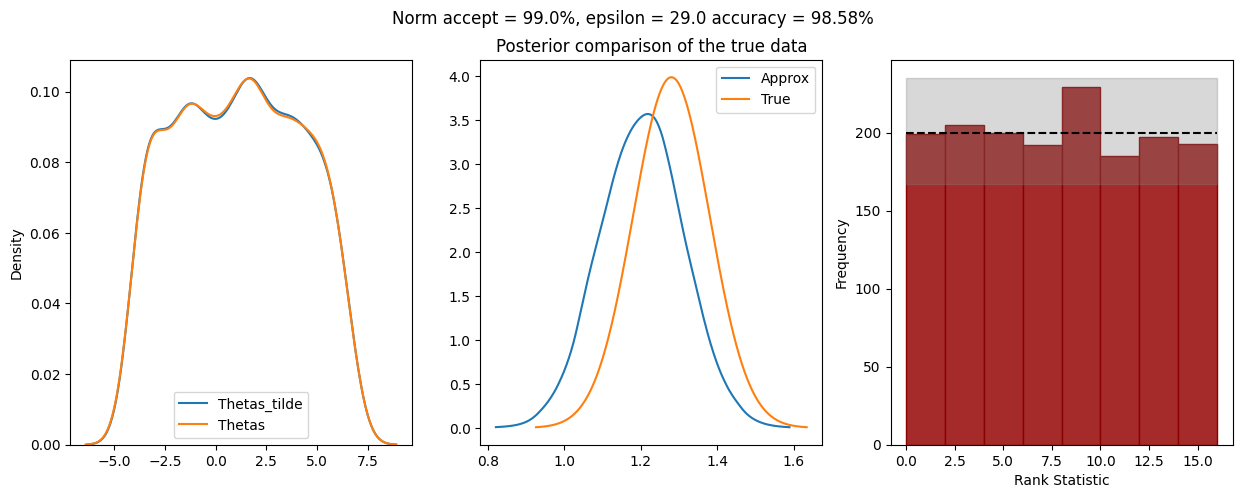

/Users/antoineluciano/Documents/Recherche/ABC-SBI/examples/Gauss-Gauss/results/figures/GaussGauss_sigma_1.0_sigma0_10.0_mu_1.0_acc_0.99_eps_29.001


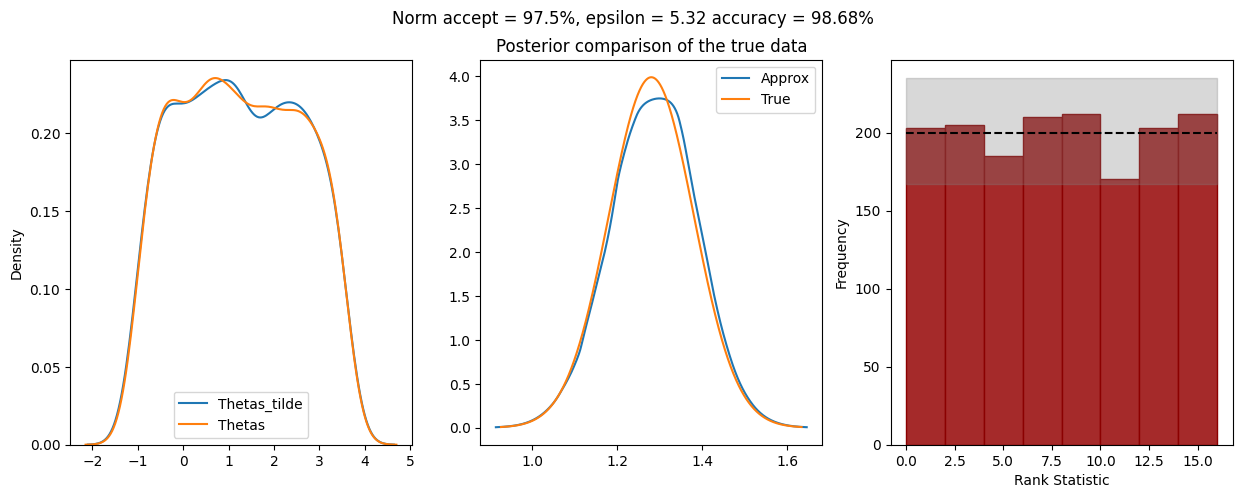

/Users/antoineluciano/Documents/Recherche/ABC-SBI/examples/Gauss-Gauss/results/figures/GaussGauss_sigma_1.0_sigma0_10.0_mu_1.0_acc_0.975_eps_5.3162


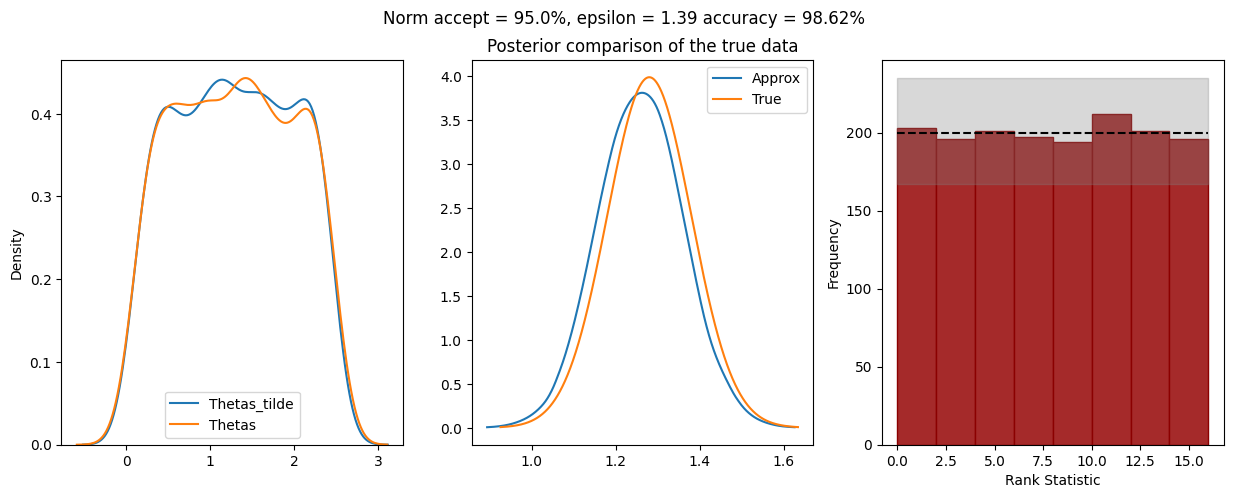

/Users/antoineluciano/Documents/Recherche/ABC-SBI/examples/Gauss-Gauss/results/figures/GaussGauss_sigma_1.0_sigma0_10.0_mu_1.0_acc_0.95_eps_1.39


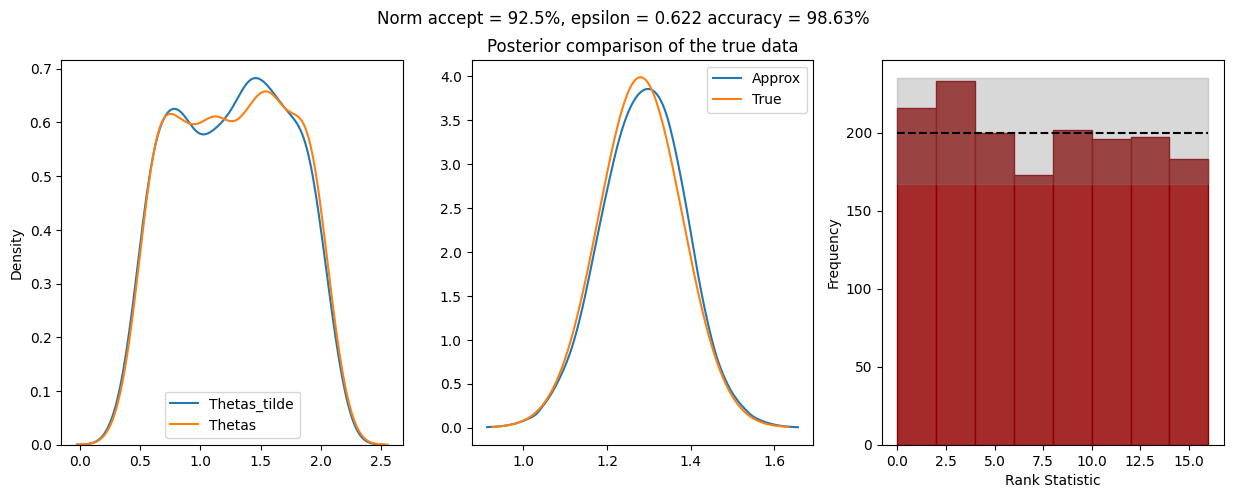

/Users/antoineluciano/Documents/Recherche/ABC-SBI/examples/Gauss-Gauss/results/figures/GaussGauss_sigma_1.0_sigma0_10.0_mu_1.0_acc_0.925_eps_0.62192


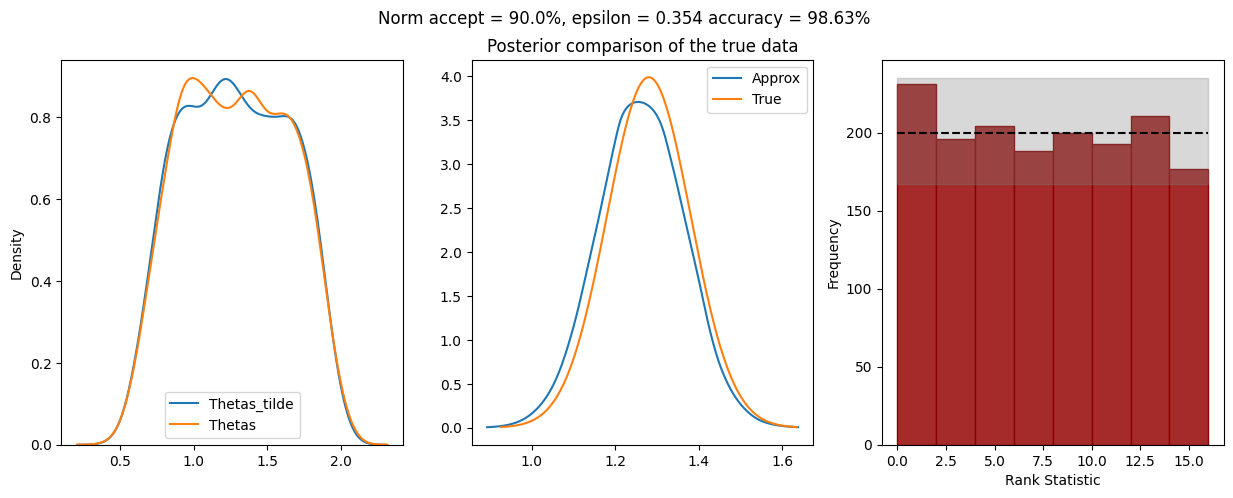

/Users/antoineluciano/Documents/Recherche/ABC-SBI/examples/Gauss-Gauss/results/figures/GaussGauss_sigma_1.0_sigma0_10.0_mu_1.0_acc_0.9_eps_0.35391


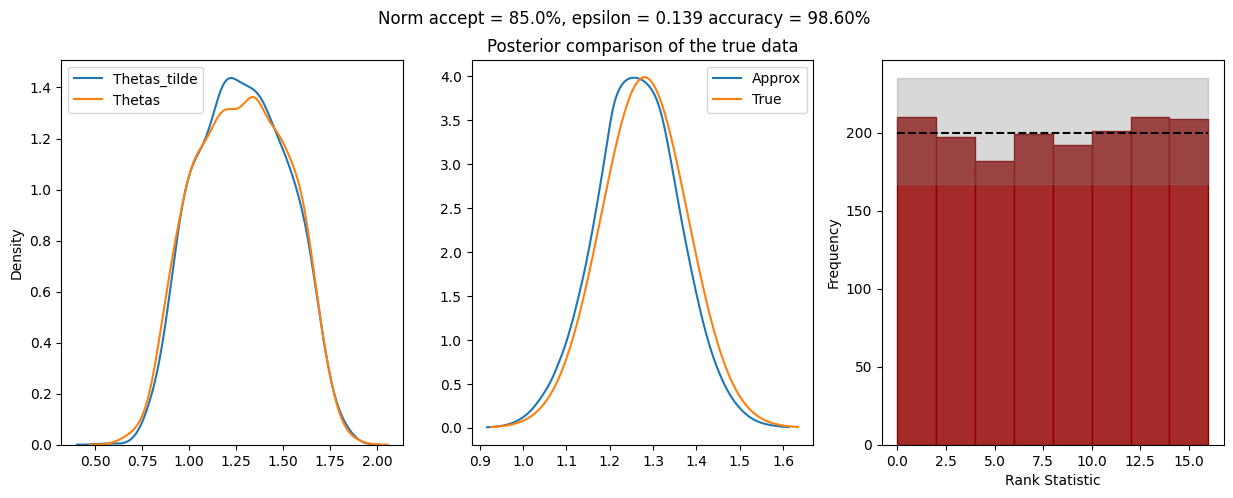

/Users/antoineluciano/Documents/Recherche/ABC-SBI/examples/Gauss-Gauss/results/figures/GaussGauss_sigma_1.0_sigma0_10.0_mu_1.0_acc_0.85_eps_0.13887


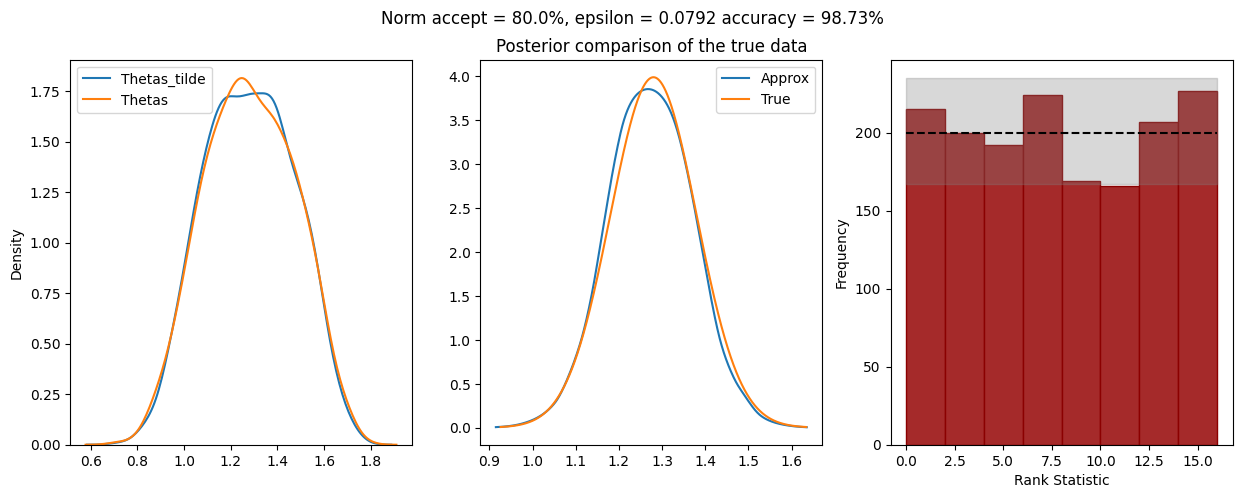

/Users/antoineluciano/Documents/Recherche/ABC-SBI/examples/Gauss-Gauss/results/figures/GaussGauss_sigma_1.0_sigma0_10.0_mu_1.0_acc_0.8_eps_0.079235


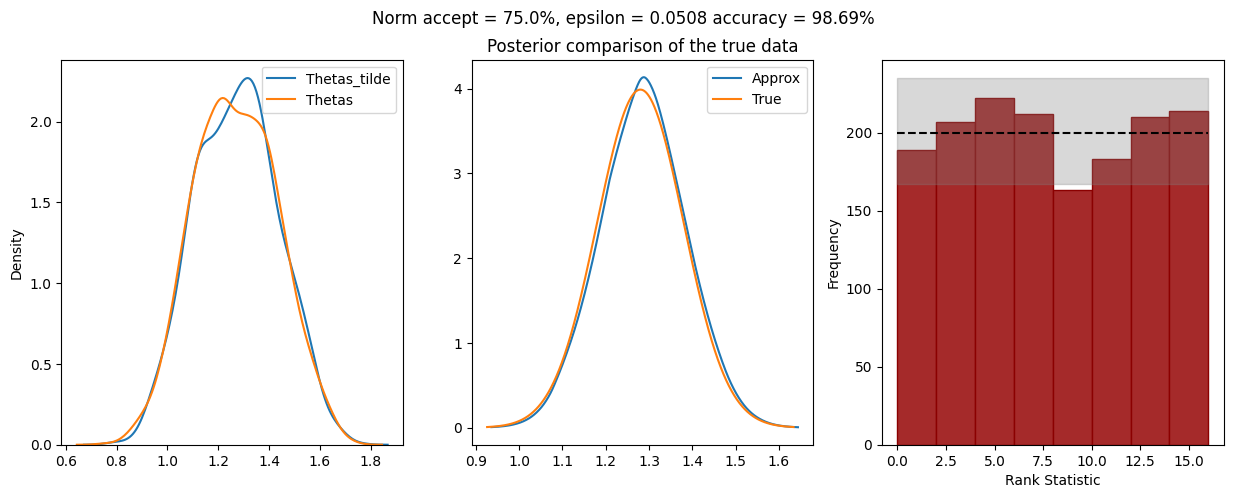

/Users/antoineluciano/Documents/Recherche/ABC-SBI/examples/Gauss-Gauss/results/figures/GaussGauss_sigma_1.0_sigma0_10.0_mu_1.0_acc_0.75_eps_0.050776


In [ ]:
from functions.SBC import post_pdf_z, find_grid_explorative
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

def true_post(z):
    mu_post = (MU0*SIGMA**2 + SIGMA0**2 * np.sum(z))/(SIGMA0**2*len(z) + SIGMA**2)
    sigma2_post = 1/(1/SIGMA0**2 + len(z)/SIGMA**2)
    return stats.norm(loc = mu_post, scale = np.sqrt(sigma2_post))

L = 15
B = 8
for ACCEPT_RATE in np.sort(ACCEPT_RATES)[::-1]:
    data = dico[ACCEPT_RATE]
    ranks = data["ranks"]
    thetas_tilde = data["thetas_tilde"]
    thetas = data["thetas"]
    epsilon = data["epsilon"]
    TRUE_DATA = data["TRUE_DATA"]
    TRUE_THETA = data["TRUE_THETA"]
    params = data["params"]
    train_accuracy = data["train_accuracy"]
    test_accuracy = data["test_accuracy"]
    MODEL_ARGS = data["MODEL_ARGS"]
    PRIOR_ARGS = data["PRIOR_ARGS"]
    N_POINTS_TRAIN = data["N_POINTS_TRAIN"]
    N_POINTS_TEST = data["N_POINTS_TEST"]
    N_DATA = data["N_DATA"]
    N_EPOCHS = data["N_EPOCHS"]
    LEARNING_RATE = data["LEARNING_RATE"]
    PATIENCE = data["PATIENCE"]
    COOLDOWN = data["COOLDOWN"]
    FACTOR = data["FACTOR"]
    RTOL = data["RTOL"]
    ACCUMULATION_SIZE = data["ACCUMULATION_SIZE"]
    LEARNING_RATE_MIN = data["LEARNING_RATE_MIN"]
    BATCH_SIZE = data["BATCH_SIZE"]
    NUM_BATCH = data["NUM_BATCH"]
    NUM_CLASSES = data["NUM_CLASSES"]
    HIDDEN_SIZE = data["HIDDEN_SIZE"]
    NUM_LAYERS = data["NUM_LAYERS"]
    WDECAY = data["WDECAY"]
    TRUE_MU = TRUE_THETA
    EPSILON_STAR = epsilon
    NAMEFILE = PATH_RESULTS+"pickle/GaussGauss_sigma_{}_sigma0_{}_mu_{}_acc_{:.3}_eps_{:.5}".format(SIGMA, SIGMA0, TRUE_MU, ACCEPT_RATE, EPSILON_STAR)
    NAMEFIG = PATH_RESULTS+"figures/GaussGauss_sigma_{}_sigma0_{}_mu_{}_acc_{:.3}_eps_{:.5}".format(SIGMA, SIGMA0, TRUE_MU, ACCEPT_RATE, EPSILON_STAR)
    MU0 = PRIOR_ARGS[0]
    SIGMA0 = PRIOR_ARGS[1]
    PRIOR_LOGPDF = lambda x: norm.logpdf(x, loc = MU0, scale = SIGMA0)
    
    SIGMA = MODEL_ARGS[0]
    accuracy = test_accuracy[-1]
    
    f, ax = plt.subplots(1,3, figsize = (15,5))
    sns.kdeplot(thetas_tilde, label = "Thetas_tilde", ax = ax[0])
    sns.kdeplot(thetas[:,0], label = "Thetas", ax = ax[0])
    
    ax[0].legend()
    f.suptitle(f'Norm accept = {ACCEPT_RATE:.1%}, epsilon = {EPSILON_STAR:.3} accuracy = {accuracy:.2%}')
    
    grid_approx, pdf_approx = find_grid_explorative(lambda x: post_pdf_z(params, x, TRUE_DATA, PRIOR_LOGPDF), 10000, 10000, MINN, MAXX)
    grid_true, pdf_true = find_grid_explorative(lambda x: true_post(TRUE_DATA).pdf(x), 10000, 10000, MINN, MAXX)
    Z_approx = np.trapz(pdf_approx, grid_approx)
    ax[1].plot(grid_approx, pdf_approx/Z_approx, label = "Approx")
    ax[1].plot(grid_true, pdf_true, label = "True")
    ax[1].legend()
    ax[1].set_title("Posterior comparison of the true data")
    plot_SBC(ranks, L, B, ax = ax[2])
    ax[2].set_title("SBC with Rank Statistics")
    print(NAMEFIG)
    f.savefig(NAMEFIG+".png")
    plt.close(f)
    
    
    

In [ ]:
def MAP_diff_epsilon(key, N_SBC, L, params, epsilon, true_data, prior_simulator, prior_logpdf, data_simulator, discrepancy, n_grid_explo = 100, n_grid_final = 1000, minn = -50, maxx = 50, X = np.array([])):
    if len(X) == 0:
        datas, thetas_tilde, _, key = ABC_epsilon(key, N_SBC, prior_simulator, data_simulator, discrepancy, epsilon, true_data)
    else:
        key, key_ = random.split(key)
        dim_theta = prior_simulator(key_).shape[0]
        datas = X[:, dim_theta:]
        thetas_tilde = X[:, :dim_theta].reshape(-1, dim_theta)
        N_SBC = len(datas)
    ranks = jnp.zeros(N_SBC)
    grids, pdf_values = jnp.zeros((N_SBC, n_grid_final)), jnp.zeros((N_SBC, n_grid_final))
    thetas = jnp.zeros((N_SBC, L))
    for i in tqdm(range(N_SBC), mininterval= N_SBC//20):
        grid, pdf_value = find_grid_explorative(lambda x: post_pdf_z(params, x, datas[i], prior_logpdf), n_grid_explo, n_grid_final, minn, maxx)
        grids = grids.at[i].set(grid)
        pdf_values = pdf_values.at[i].set(pdf_value)
    thetas, key = post_sample_batch(key, grids, pdf_values, L)
    ranks = jnp.sum(thetas < thetas_tilde, axis = 1)
    return ranks, thetas_tilde, thetas, key

# Test KDE

In [43]:
key = random.PRNGKey(0)
 
MU0 = 0.
SIGMA = 1.
MODEL_ARGS = [SIGMA]
N_DATA = 100
N_POINTS_TRAIN = 1000000
N_POINTS_TEST = 100000
N_POINTS_EPS = 1000
sim_args = None


N_EPOCHS = 100
LEARNING_RATE = 0.001
PATIENCE = 7
COOLDOWN = 0
FACTOR = .5
RTOL = 1e-4  
ACCUMULATION_SIZE = 200
LEARNING_RATE_MIN = 1e-6

BATCH_SIZE = 256
NUM_BATCH = 1024
NUM_CLASSES = 2
HIDDEN_SIZE = 256
NUM_LAYERS = 7
WDECAY = .001
N_GRID_FINAL = 10000
N_GRID_EXPLO = 1000
L = 63
B = 16
N_SBC = (L+1)*1

PATH_RESULTS = os.getcwd() + "/examples/Gauss-Gauss/results/"
if not os.path.exists(PATH_RESULTS):
    os.makedirs(PATH_RESULTS)
    


SIGMAS0 = [2*SIGMA]
ACCEPT_RATES = [.5]


for SIGMA0 in SIGMAS0:
    PATH_SIGMA0 = PATH_RESULTS+ "sigma0_{}/".format(SIGMA0)
    if not os.path.exists(PATH_SIGMA0):
        os.makedirs(PATH_SIGMA0)
        
    TRUE_MUS = [.1*SIGMA0]
    PRIOR_ARGS = [MU0, SIGMA0]
    PRIOR_LOGPDF = lambda x: norm.logpdf(x, loc = MU0, scale = SIGMA0)
    MINN, MAXX = norm.ppf(1e-5, loc = MU0, scale = SIGMA0), norm.ppf(1-1e-5, loc = MU0, scale = SIGMA0)
    
    for TRUE_MU in TRUE_MUS:
        PATH_TRUE_MU = PATH_SIGMA0 + "mu_{}/".format(TRUE_MU)
        if not os.path.exists(PATH_TRUE_MU):
            os.makedirs(PATH_TRUE_MU)
        EPSILON_STAR = .04
    
        key, subkey = random.split(key)
        TRUE_DATA = data_simulator(subkey, TRUE_MU)
        for ACCEPT_RATE in ACCEPT_RATES:
            print("\n\n--------------------")
            print("SIGMA0 = {}, TRUE_MU = {}, ACCEPT_RATE = {}".format(SIGMA0, TRUE_MU, ACCEPT_RATE))
            print("--------------------\n\n")
                    
            
            time_eps = time.time()
            print("Selection of epsilon star...")
            EPSILON_STAR, key = get_epsilon_star(key, ACCEPT_RATE, N_POINTS_EPS, prior_simulator, data_simulator, discrepancy, TRUE_DATA, quantile_rate = .9, epsilon = EPSILON_STAR)
            print('Time to select epsilon star: {:.2f}s\n'.format(time.time()-time_eps))

            print("Simulations of the testing dataset...")
            time_sim = time.time()
            X_test, y_test, key = get_newdataset(key, N_POINTS_TEST, prior_simulator, data_simulator, discrepancy, EPSILON_STAR, TRUE_DATA)
            print('Time to simulate the testing dataset: {:.2f}s\n'.format(time.time()-time_sim))

            print("Simulations of the training dataset...")
            time_sim = time.time()
            X_train, y_train, key = get_newdataset(key, N_POINTS_TRAIN, prior_simulator, data_simulator, discrepancy, EPSILON_STAR, TRUE_DATA)
            print('Time to simulate the training dataset: {:.2f}s\n'.format(time.time()-time_sim))


            print("Training the neural network...")
            time_nn = time.time()
            params, train_accuracy, train_losses, test_accuracy, test_losses, key = train_loop(key, N_EPOCHS, NUM_LAYERS, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE, NUM_BATCH, LEARNING_RATE, WDECAY, PATIENCE, COOLDOWN, FACTOR, RTOL, ACCUMULATION_SIZE, LEARNING_RATE_MIN, prior_simulator, data_simulator, discrepancy, true_data = TRUE_DATA, X_train = X_train, y_train = y_train, X_test = X_test, y_test =  y_test, N_POINTS_TRAIN = N_POINTS_TRAIN, N_POINTS_TEST = N_POINTS_TEST, epsilon = EPSILON_STAR, verbose = True)
            print('Time to train the neural network: {:.2f}s\n'.format(time.time()-time_nn))


            # print("Simulation Based Calibration...")
            # time_sbc = time.time()

            # ranks, thetas_tilde, thetas, key = SBC_epsilon(key = key, N_SBC = N_SBC, L = L, params = params, epsilon = EPSILON_STAR, true_data = TRUE_DATA, prior_simulator = prior_simulator, prior_logpdf = PRIOR_LOGPDF, data_simulator = data_simulator, discrepancy = discrepancy, n_grid_explo = N_GRID_EXPLO, n_grid_final = N_GRID_FINAL, minn = MINN, maxx = MAXX)

            # print('Time to perform SBC: {:.2f}s\n'.format(time.time()-time_sbc))


            # pickle_dico = {"ACCEPT_RATE":ACCEPT_RATE, "ranks": ranks, "thetas_tilde": thetas_tilde, "thetas": thetas, "epsilon":EPSILON_STAR, "KEY":key, "N_SBC":N_SBC, "L":L, "N_GRID_EXPLO": N_GRID_EXPLO, 'N_GRID_FINAL': N_GRID_FINAL,"TRUE_DATA": TRUE_DATA, "TRUE_THETA": TRUE_MU, "params": params, "train_accuracy":train_accuracy, "test_accuracy":test_accuracy, "MODEL_ARGS":MODEL_ARGS, "PRIOR_ARGS":PRIOR_ARGS, "N_POINTS_TRAIN":N_POINTS_TRAIN, "N_POINTS_TEST":N_POINTS_TEST, "N_DATA":N_DATA, "N_EPOCHS":N_EPOCHS, "LEARNING_RATE":LEARNING_RATE, "PATIENCE":PATIENCE, "COOLDOWN":COOLDOWN, "FACTOR":FACTOR, "RTOL":RTOL, "ACCUMULATION_SIZE":ACCUMULATION_SIZE, "LEARNING_RATE_MIN":LEARNING_RATE_MIN, "BATCH_SIZE":BATCH_SIZE, "NUM_BATCH":NUM_BATCH, "NUM_CLASSES":NUM_CLASSES, "HIDDEN_SIZE":HIDDEN_SIZE, "NUM_LAYERS":NUM_LAYERS, "WDECAY":WDECAY}


            # NAME = "GaussGauss_sigma_{}_sigma0_{}_mu_{}_acc_{:.3}_eps_{:.5}".format(SIGMA, SIGMA0, TRUE_MU, ACCEPT_RATE, EPSILON_STAR)
            # NAMEFIG = PATH_TRUE_MU+'figures/'+NAME+".png"
            # NAMEFILE = PATH_TRUE_MU+'pickles/'+NAME+".xy"
            
            # if not os.path.exists(PATH_TRUE_MU+'figures/'):
            #     os.makedirs(PATH_TRUE_MU+'figures/')
            # if not os.path.exists(PATH_TRUE_MU+'pickles/'):
            #     os.makedirs(PATH_TRUE_MU+'pickles/')
                
            
            # with lzma.open(NAMEFILE, "wb") as f:
            #     pickle.dump(pickle_dico, f)
            # print("Data saved in ", NAMEFILE)

            # title = "Normal w/ known std\nsigma = {}, sigma0 = {} mu = {}\nalpha = {:.2%}, eps = {:.3} accuracy = {:.2%}".format(SIGMA, SIGMA0, TRUE_MU, ACCEPT_RATE, EPSILON_STAR, test_accuracy[-1])
    
            
            # f, ax = plt.subplots(1,3, figsize = (15,5))
            # sns.kdeplot(thetas_tilde, label = "Thetas_tilde", ax = ax[0])
            # sns.kdeplot(thetas[:,0], label = "Thetas", ax = ax[0])

            # ax[0].legend()
            # f.suptitle(f'GaussGauss with sigma = {SIGMA} sigma0 = {SIGMA0} mu = {TRUE_MU} alpha = {ACCEPT_RATE:.1%}, epsilon = {EPSILON_STAR:.3} accuracy = {test_accuracy[-1]:.2%}')

            # grid_approx, pdf_approx = find_grid_explorative(lambda x: post_pdf_z(params, x, TRUE_DATA, PRIOR_LOGPDF), N_GRID_EXPLO, N_GRID_FINAL, MINN, MAXX)
            # grid_true, pdf_true = find_grid_explorative(lambda x: true_post(TRUE_DATA).pdf(x), N_GRID_EXPLO, N_GRID_FINAL, MINN, MAXX)
            
            # Z_approx = np.trapz(pdf_approx, grid_approx)
            # ax[1].plot(grid_approx, pdf_approx/Z_approx, label = "Approx")
            # ax[1].plot(grid_true, pdf_true, label = "True")
            # ax[1].legend()
            # ax[1].set_title("Posterior comparison of the true data")
            # plot_SBC(ranks, L, B, ax = ax[2])
            # ax[2].set_title("SBC with Rank Statistics")
            # f.savefig(NAMEFIG)
            # plt.close(f)
            
            
            
            
            
            # print("\n\n--------------------")
            # print("ITERATION (ACC = {}) DONE IN {} SECONDS!".format(ACCEPT_RATE, time.time()-time_eps))
            # print("--------------------\n\n")



--------------------
SIGMA0 = 2.0, TRUE_MU = 0.2, ACCEPT_RATE = 0.5
--------------------


Selection of epsilon star...
epsilon:  0.03214426711201668 acceptance rate:  0.67700005
epsilon:  0.02636525221168995 acceptance rate:  0.666
epsilon:  0.02139911614358425 acceptance rate:  0.615
epsilon:  0.017522180452942848 acceptance rate:  0.611
epsilon:  0.014603443443775177 acceptance rate:  0.57100004
epsilon:  0.01168525405228138 acceptance rate:  0.53300005
epsilon:  0.009539433754980564 acceptance rate:  0.476
Time to select epsilon star: 6.35s

Simulations of the testing dataset...
Time to simulate the testing dataset: 9.02s

Simulations of the training dataset...
Time to simulate the training dataset: 89.52s

Training the neural network...
Initial accuracy: 49.57%, Initial test accuracy: 49.64%
Training for 100 epochs...
Epoch 1/100, mean train accuracy: 91.49%, mean test accuracy: 93.40%, lr scale: 1.0 in 9.10 sec
Epoch 2/100, mean train accuracy: 93.81%, mean test accuracy: 93.65

/Users/antoineluciano/.pyenv/versions/3.10.13/envs/jax_env/lib/python3.10/site-packages/numpy/lib/function_base.py:4791: RuntimeWarning: overflow encountered in add
  ret = (d * (y[tuple(slice1)] + y[tuple(slice2)]) / 2.0).sum(axis)
/var/folders/bc/mlt2yzpn2hsg7qskk5s47jy40000gn/T/ipykernel_15264/1186315991.py:17: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(grid_lkl, pdf_lkl/Z_lkl, label = "Likelihood")


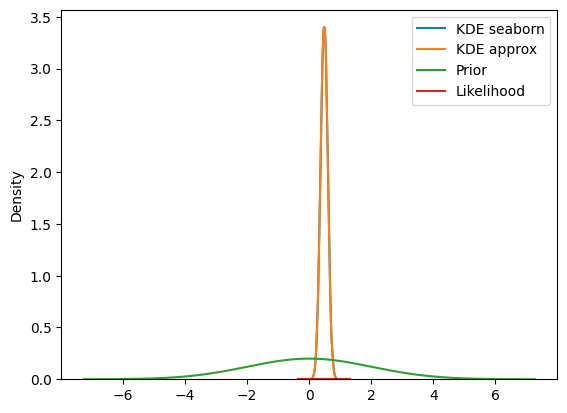

In [45]:
thetas = X_train[:100000, :1].flatten()
from jax.scipy.stats import norm, gaussian_kde
from functions.SBC import new_post_pdf_z

kde_approx = gaussian_kde(thetas.flatten())
prior = lambda x: norm.pdf(x, loc = MU0, scale = SIGMA0)
likelihood = lambda x: jnp.exp(jnp.sum((x-TRUE_DATA)**2)/(2*SIGMA**2))
sns.kdeplot(thetas, label = 'KDE seaborn')
grid_kde_approx, pdf_kde_approx = find_grid_explorative(kde_approx, 1000, 1000, MINN, MAXX)
grid_prior, pdf_prior = find_grid_explorative(prior, 1000, 1000, MINN, MAXX)
grid_lkl = np.linspace(-5, 5, 1000)
pdf_lkl = np.array([likelihood(x) for x in grid_lkl])
Z_lkl = np.trapz(pdf_lkl, grid_lkl)

plt.plot(grid_kde_approx, pdf_kde_approx, label = "KDE approx")
plt.plot(grid_prior, pdf_prior, label = "Prior")
plt.plot(grid_lkl, pdf_lkl/Z_lkl, label = "Likelihood")
plt.legend()


In [46]:
# grid_approx_with_kde, pdf_approx_with_kde = find_grid_explorative(lambda x: new_post_pdf_z(params, x, TRUE_DATA, kde_approx), N_GRID_EXPLO, N_GRID_FINAL, MINN, MAXX)

grid_approx_with_kde = np.linspace(0, 1, 10000)
pdf_approx_with_kde = new_post_pdf_z(params, grid_approx_with_kde, TRUE_DATA, kde_approx)

0.9996698225310078 13.903751832555281 1.0273098


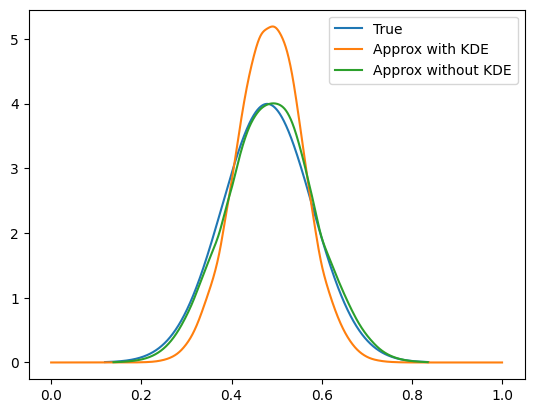

In [47]:
Z_true = np.trapz(pdf_true, grid_true)
Z_approx_with_kde = np.trapz(pdf_approx_with_kde, grid_approx_with_kde)
# Z_approx_with_kde=1
Z_approx_without_kde = np.trapz(pdf_approx_without_kde, grid_approx_without_kde)
print(Z_true, Z_approx_with_kde, Z_approx_without_kde)
plt.plot(grid_true, pdf_true/Z_true, label = "True")
plt.plot(grid_approx_with_kde, pdf_approx_with_kde/Z_approx_with_kde, label = "Approx with KDE")
plt.plot(grid_approx_without_kde, pdf_approx_without_kde/Z_approx_without_kde, label = "Approx without KDE")
plt.legend()
